#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.5em; color:#00b3e5;"> WaveNet - Stock Market Prediction
 - Note: **Date** is **( Optional )**

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Libraries

In [1]:
import pickle, warnings
warnings.filterwarnings('ignore')

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from   sklearn.linear_model               import LinearRegression
from   statsmodels.tsa.statespace.sarimax import SARIMAX            # Seasonal ARIMA
from   tensorflow                         import keras

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Data

In [2]:
Project_Name = 'Google_Stock_Price'

data = pd.read_csv('Google_Stock_Price.csv')
data.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"


In [3]:
# input
sclr = 'Low'

# auto
C = data[[sclr]].copy()
#for i in range(C.shape[0]):  C.loc[i,sclr] = C.loc[i,sclr].replace(",","") 

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> LOAD 

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

In [ ]:
TimeSeries         = C.astype(float)
TimeSeries.columns =   ['Series']
TimeSeries.tail(3)

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:orange;"> (optional) index = Date

In [ ]:
TimeSeries.index = pd.to_datetime( data['Date'].values, format='%m/%d/%Y')
TimeSeries.tail(3)

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> Smooting Series

In [ ]:
def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

def smoother2( df, ft, n ):   # Keeps Sharpness ( Good for small data-sets )
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+3*s[i]+s[i+1] ) / 5
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+3*s[i]+s[i+1] ) / 5
    noise = df[ft].values.copy() - s
    return s, noise

# input
n_smoothing = 1
smoothed, noise = smoother( TimeSeries, 'Series', n_smoothing )

# auto
TimeSeries[     'Noise'     ] = np.round( noise, 0 )  
TimeSeries['Smoothed_Series'] = np.round( smoothed, 0 ) 
TimeSeries.tail(3)

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Visualizing Smoothed-Series & Noise

In [ ]:
Range = range(TimeSeries.shape[0])
plt.figure(figsize=(13,3))
plt.plot(Range,TimeSeries[    'Series'     ],color='c',linewidth=2, label='unsmoothed' ) 
plt.plot(Range,TimeSeries['Smoothed_Series'],color='r',linewidth=1, label='  smoothed' )
plt.legend(); plt.show()

plt.figure(figsize=(13,3))
plt.plot( [Range[0],Range[-1]], [0,0], color='deeppink'  , linewidth=1, linestyle=':' )
plt.plot(  Range, TimeSeries['Noise'], color='dodgerblue', linewidth=1, label='noise' ) 
mx=max(abs(TimeSeries['Noise']));plt.gca().set_ylim(-mx,+mx); plt.legend()
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Trend & Initial_Value

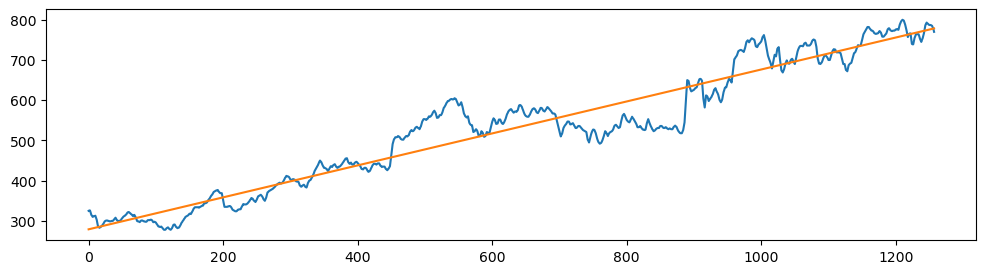

In [54]:
# Tend
T = pd.DataFrame( range( TimeSeries[ 'Smoothed_Series' ].shape[0] ))  
model = LinearRegression().fit( T, TimeSeries[['Smoothed_Series']] ) 

# trnd & initial values
trend         = model.coef_[0]     # slope
initial_value = model.intercept_   # intercept

# Trend
trend_line = trend*T + initial_value
TimeSeries['Trend'] = trend_line.values

# Plot
plt.figure(figsize=(12,3))
plt.plot( T, TimeSeries[['Smoothed_Series']] )
plt.plot( T, TimeSeries['Trend'] )
plt.show()

#####    

#####    

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclic_Seasonality

In [ ]:
#residual = y.values - trend_line.values
TimeSeries['Cyclic_Seasonality'] = TimeSeries['Smoothed_Series'] - TimeSeries['Trend']
TimeSeries.tail(3)

In [ ]:
plt.figure( figsize=(12,3) )
plt.plot( [0,len(T)], [0,0], ':', color='deeppink' )
plt.plot( T, TimeSeries['Cyclic_Seasonality'], color='dodgerblue' )
plt.show()

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:orange;"> ( Optional ) Extracting Y, M, D from Dates

In [ ]:
Dates = TimeSeries.index.date.tolist()
Dates[:3]

In [ ]:
Dates = pd.to_datetime(Dates, format='%m/%d/%Y')
Dates[:3]

In [ ]:
df = pd.DataFrame()
df.index = Dates
df['Year' ] = Dates.year
df['month'] = Dates.month
df[ 'day' ] = Dates.day
df.sample(3)

In [ ]:
Seasons = pd.concat([df,TimeSeries],axis=1) 
Seasons.tail(3)

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:orange;"> ( Optional ) Visualizing Cyclic Seasonality

In [ ]:
def plot_monthly_seasonality( df, ft, Month ): 
    A = df.loc[ df['month']==Month, ['day',ft] ].groupby('day').mean() 
    plt.figure(figsize=(13,1.5))
    plt.plot( [1,31],  [0,0], ':',  color='deeppink'   )
    plt.plot( A.index, A[ft], '-o', color='dodgerblue' )  
    YLIM = max(abs(df[ft]))
    plt.gca().set_ylim(-YLIM,+YLIM)
    plt.title('Month '+str(Month))
    plt.show()
    
for i in range(1,13):
    plot_monthly_seasonality( Seasons, 'Cyclic_Seasonality', i )

#####    

#####    

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> Cyclicity

In [ ]:
res = TimeSeries['Cyclic_Seasonality'].values.copy()
T   = range( len(res) ) 
As, ws, Lags = [],[],[]

for i in range(1):
    # The Function To Be Minimized 
    def obj_func(p):   
        A, w, lag  = p  
        sig = []
        for t in range(TimeSeries.shape[0]):
            sig.append( A * np.sin( w*t + lag )  )
        SE = [ (i-j)**2 for i,j in zip(res,sig) ]
        return ( sum(SE)/len(SE) ) ** 0.5

    from sko.GA import GA
    ga = GA( func      = obj_func
           , n_dim     = 3
           , size_pop  = 200 
           , max_iter  = 100 
           , ub        = [2*np.max(res), 2*np.pi, 2*np.pi]
           , lb        = [   0.00001,    0.00001, 0.00001]
           , prob_mut  = 0.05
           , precision = 0.0001
           )
    Best_X, Best_y = ga.fit()
    A, w, Lag = Best_X
    As.append(A)
    ws.append(w)
    Lags.append(Lag)    
    print([i, Best_X, Best_y])
    sig = [ A*np.sin(w*t+Lag) for t in T ]
    res = res - sig
    
df_Cyclicity = pd.DataFrame()
df_Cyclicity['Cycle'] = range(len(As))
df_Cyclicity[  'A'  ] =  As
df_Cyclicity[  'w'  ] =  ws
df_Cyclicity[ 'Lag' ] = Lags 

res = TimeSeries['Cyclic_Seasonality'].values.copy()
T   = range( TimeSeries.shape[0] ) 

SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A' ]
    w   = df_Cyclicity.loc[i, 'w' ]
    Lag = df_Cyclicity.loc[i,'Lag']
    sig = [ A*np.sin(w*t+Lag) for t in T ]
    SIG = [ i+j for i,j in zip(SIG,sig) ]
TimeSeries['Cyclicity'] = SIG
    
plt.figure(figsize=(12,3))
plt.plot( [0,len(T)], [0,0], color='deeppink', linestyle=":" )
plt.plot(    T,        res , color='dodgerblue' )
plt.plot(    T,        SIG , color='orange'     )
plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [ ]:
df_Cyclicity

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [ ]:
TimeSeries.tail(3)

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> continue ...

[24, array([2.58017905, 0.21035839, 0.40757198]), 9.847497868736529]
[25, array([3.34344463, 6.20092509, 0.81403141]), 9.619619935412489]


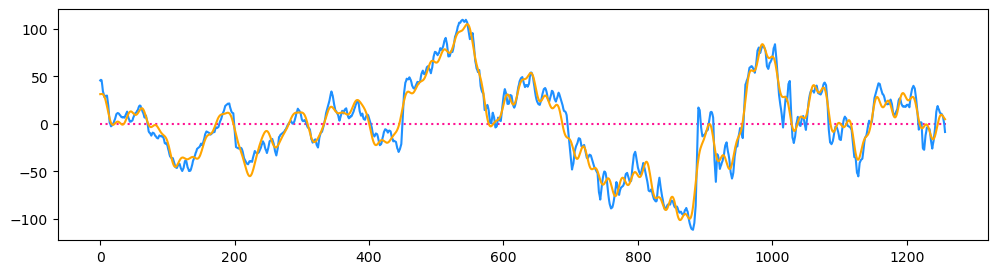

In [13]:
# input
n_Extra = 2

# auto
try:
    df_Cyclicity = pickle.load( open(Project_Name + '_df_Cyclicity','rb') )  # load
    TimeSeries   = pickle.load( open(Project_Name + '_TimeSeries'  ,'rb') )  # load
except:
    ;
    
res  = TimeSeries['Cyclic_Seasonality'].values.copy() - TimeSeries['Cyclicity'].values.copy() 
T    = range( TimeSeries.shape[0] )
As   = df_Cyclicity[ 'A' ].values.copy().tolist()
ws   = df_Cyclicity[ 'w' ].values.copy().tolist()
Lags = df_Cyclicity['Lag'].values.copy().tolist()

for i in range( len(As), len(As)+n_Extra ):
    # The Function To Be Minimized 
    def obj_func(p):   
        A, w, lag  = p  
        sig = []
        for t in range(TimeSeries.shape[0]):
            sig.append( A * np.sin( w*t + lag )  )
        SE = [ (i-j)**2 for i,j in zip(res,sig) ]
        return ( sum(SE)/len(SE) ) ** 0.5

    from sko.GA import GA
    ga = GA( func      = obj_func
           , n_dim     = 3
           , size_pop  = 200 
           , max_iter  = 100 
           , ub        = [2*np.max(res), 2*np.pi, 2*np.pi]
           , lb        = [   0.00001,    0.00001, 0.00001]
           , prob_mut  = 0.05
           , precision = 0.0001
           )
    Best_X, Best_y = ga.fit()
    A, w, Lag = Best_X
    As.append(A)
    ws.append(w)
    Lags.append(Lag)    
    print([i, Best_X, Best_y])
    sig = [ A*np.sin(w*t+Lag) for t in T ]
    res = res - sig
    
df_Cyclicity = pd.DataFrame()
df_Cyclicity['Cycle'] = range(len(As))
df_Cyclicity[  'A'  ] =  As
df_Cyclicity[  'w'  ] =  ws
df_Cyclicity[ 'Lag' ] = Lags

# Save & Plot
CS  = TimeSeries['Cyclic_Seasonality'].values.copy() 

SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A' ]
    w   = df_Cyclicity.loc[i, 'w' ]
    Lag = df_Cyclicity.loc[i,'Lag']
    sig = [ A*np.sin(w*t+Lag) for t in T ]
    SIG = [ i+j for i,j in zip(SIG,sig)  ]
TimeSeries['Cyclicity'] = SIG

plt.figure(figsize=(12,3))
plt.plot( [0,len(T)], [0,0], color='deeppink', linestyle=":" )
plt.plot(    T,        CS  , color='dodgerblue' )
plt.plot(    T,        SIG , color='orange'     )
plt.show()

#####    

#####    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclic Trend

In [5]:
TimeSeries['Cyclic_Trend'] = TimeSeries['Trend']+TimeSeries['Cyclicity']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend
2016-12-28,783.20,2.0,781.0,777.730615,3.269385,8.885342,786.615958
2016-12-29,778.92,2.0,777.0,778.127888,-1.127888,7.234289,785.362176
2016-12-30,770.41,0.0,770.0,778.525160,-8.525160,5.830206,784.355366


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

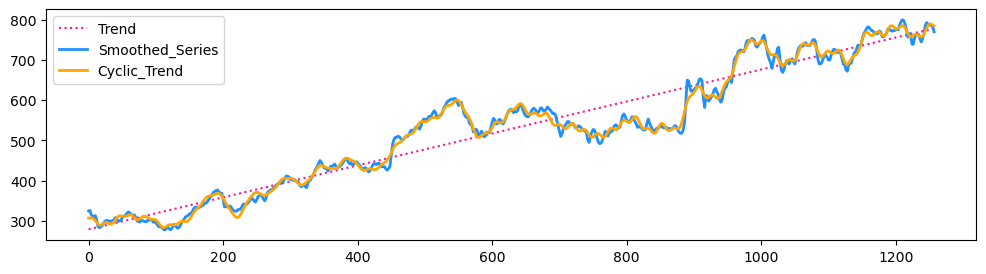

In [6]:
T = range( TimeSeries.shape[0] )
y1 = TimeSeries['Trend']
y2 = TimeSeries['Smoothed_Series']
y3 = TimeSeries['Cyclic_Trend']

plt.figure(figsize=(12,3))
plt.plot(T,y1,color='deeppink'  ,linestyle=':',label='Trend'          )
plt.plot(T,y2,color='dodgerblue',linewidth=2  ,label='Smoothed_Series')
plt.plot(T,y3,color='orange'    ,linewidth=2  ,label='Cyclic_Trend'   )
plt.legend()
plt.show()

#####    

#####    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Save

In [59]:
pickle.dump( trend        ,  open(Project_Name + '_trend'        ,'wb') )  # save
pickle.dump( initial_value,  open(Project_Name + '_initial_value','wb') )  # save
pickle.dump( df_Cyclicity ,  open(Project_Name + '_df_Cyclicity' ,'wb') )  # save
pickle.dump( TimeSeries   ,  open(Project_Name + '_TimeSeries'   ,'wb') )  # save

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Load

In [84]:
trend         = pickle.load( open(Project_Name + '_trend'        ,'rb') )  # load
initial_value = pickle.load( open(Project_Name + '_initial_value','rb') )  # load
df_Cyclicity  = pickle.load( open(Project_Name + '_df_Cyclicity' ,'rb') )  # load
TimeSeries    = pickle.load( open(Project_Name + '_TimeSeries'   ,'rb') )  # load

#####    

#####    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Seasonality

In [85]:
TimeSeries['Seasonality'] = TimeSeries['Cyclic_Seasonality'] - TimeSeries['Cyclicity']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend,Seasonality
2016-12-28,783.20,2.0,781.0,777.730615,3.269385,6.980047,788.336912,-3.710662
2016-12-29,778.92,2.0,777.0,778.127888,-1.127888,5.867668,789.155775,-6.995555
2016-12-30,770.41,0.0,770.0,778.525160,-8.525160,4.947717,789.926515,-13.472877


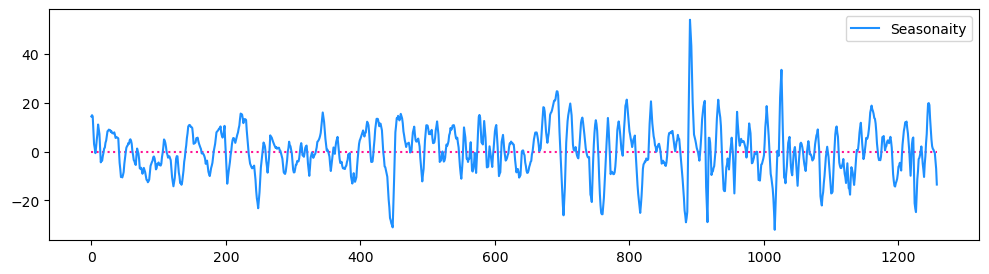

In [86]:
T = range( TimeSeries.shape[0] )
y = TimeSeries['Seasonality'] 

plt.figure(figsize=(12,3))
plt.plot([T[0],T[-1]],[0,0],color='deeppink', linestyle=':'        )
plt.plot(T,y,color='dodgerblue', linestyle='-', label='Seasonaity' )
plt.legend()
plt.show()

#####    

#####    

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> SARIMA

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> n_Test
 - **choosing the last n records as test (shown in orange)**

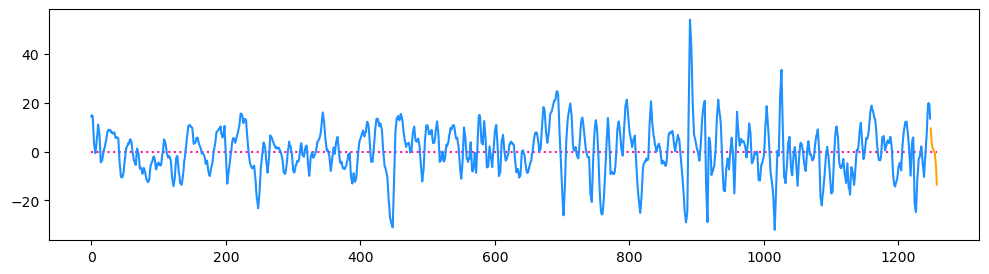

In [87]:
# input
n = 10   # n = n_Steps = n_Test

# Serie 
Series   = TimeSeries['Seasonality'].values.tolist()[:-n]
n_Series = len(Series)
T_Series = range(n_Series)

# Test
Test     = TimeSeries['Seasonality'].values.tolist()[-n:]
n_Test   = n
T_Test   = range( n_Series, n_Series+n_Test )

# Visualization
plt.figure(figsize=(12,3)); 
plt.plot( [T_Series[0],T_Test[-1]],[0,0], ":", color='deeppink' )
plt.plot( T_Series, Series, color='dodgerblue' )
plt.plot( T_Test  , Test  , color='orange'     )
plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checking
 - **checking if Time-Series is Trend-Stationary (meaning both mean and std remain constant over time)**

In [88]:
from statsmodels.tsa.stattools import adfuller

print("\nAugmented Dickey-Fuller Unit Root Test") 
stat, p, lags, obs, crit, t = adfuller( Series )

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: 
    print('\nWarning!')
    print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)  ---   NOT OK')
    print('Hint: Add more Cycles')
else: 
    print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)  ---   OK')


Augmented Dickey-Fuller Unit Root Test
stat=-6.932, p=0.000
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)  ---   OK


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [89]:
from statsmodels.tsa.stattools import kpss
print("\nKwiatkowski-Phillips-Schmidt-Shin Test")  
stat, p, lags, crit = kpss( Series )
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: 
    print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)  ---   OK')
else: 
    print('\nWarning!')
    print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)  ---   NOT OK')
    print('Hint: Add more Cycles')


Kwiatkowski-Phillips-Schmidt-Shin Test
stat=0.087, p=0.100
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)  ---   OK


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

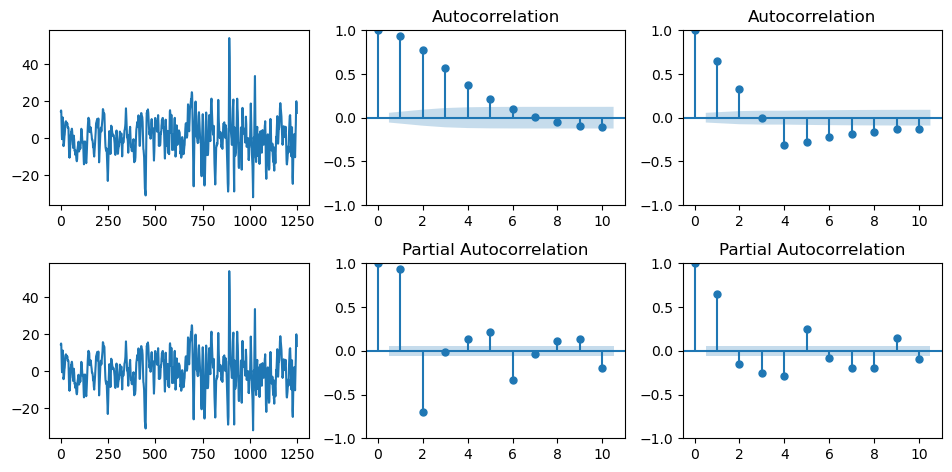

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = pd.DataFrame(Series)
fig, axes = plt.subplots(2,3)
axes[0,0].plot(ts)
plot_acf( ts, lags=n_Test, ax=axes[0,1] )
plot_acf( ts.diff().dropna(), lags=n_Test, ax=axes[0,2] )
axes[1,0].plot(ts)
plot_pacf( ts, lags=n_Test, ax=axes[1,1] )
plot_pacf( ts.diff().dropna(), lags=n_Test, ax=axes[1,2] )
plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=(0, 0, 1.5, 1))

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [11]:
PDQs, RMSEs,AICs,BICs = [], [], [], []

n_pq = 6
for p in range(n_pq):
    for d in range(2):
        for q in range(n_pq):
            
            try:
                sarimax = SARIMAX(
                    endog                   =  Series,
                    order                   = (p,d,q),
                    seasonal_order          = (0, 0, 0, 0),
                    trend_offset            =  1,
                    trend                   =  None,   # None,'n','c','t','ct'
                    exog                    =  None,
                    dates                   =  None,
                    freq                    =  None,
                    mle_regression          =  True,
                    enforce_stationarity    =  True,
                    enforce_invertibility   =  True,
                    validate_specification  =  True,
                    time_varying_regression =  False,
                    hamilton_representation =  False, 
                    simple_differencing     =  False,
                    concentrate_scale       =  False,
                    measurement_error       =  False,
                    use_exact_diffuse       =  False,   
                    missing                 = 'none'
                    )
                model = sarimax.fit()
                
                print( 'p, d, q =', [p,d,q] )
         
                PRED    = [ x for x in model.forecast(steps=n_Test) ] 
                SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
                RMSE    =   (np.sum(SE)/n_Test)**0.5
                RMSEs.append(np.round(RMSE,1))
                
                PDQs.append( (p,d,q) )
                AICs.append(int(np.round(model.aic,-1)))
                BICs.append(int(np.round(model.bic,-1)))
        
            except:
                continue

p, d, q = [0, 0, 0]
p, d, q = [0, 0, 1]
p, d, q = [0, 0, 2]
p, d, q = [0, 0, 3]
p, d, q = [0, 0, 4]
p, d, q = [0, 0, 5]
p, d, q = [0, 1, 0]
p, d, q = [0, 1, 1]
p, d, q = [0, 1, 2]
p, d, q = [0, 1, 3]
p, d, q = [0, 1, 4]
p, d, q = [0, 1, 5]
p, d, q = [1, 0, 0]
p, d, q = [1, 0, 1]
p, d, q = [1, 0, 2]
p, d, q = [1, 0, 3]
p, d, q = [1, 0, 4]
p, d, q = [1, 0, 5]
p, d, q = [1, 1, 0]
p, d, q = [1, 1, 1]
p, d, q = [1, 1, 2]
p, d, q = [1, 1, 3]
p, d, q = [1, 1, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [1, 1, 5]
p, d, q = [2, 0, 0]
p, d, q = [2, 0, 1]
p, d, q = [2, 0, 2]
p, d, q = [2, 0, 3]
p, d, q = [2, 0, 4]
p, d, q = [2, 0, 5]
p, d, q = [2, 1, 0]
p, d, q = [2, 1, 1]
p, d, q = [2, 1, 2]
p, d, q = [2, 1, 3]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [2, 1, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [2, 1, 5]
p, d, q = [3, 0, 0]
p, d, q = [3, 0, 1]
p, d, q = [3, 0, 2]
p, d, q = [3, 0, 3]
p, d, q = [3, 0, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [3, 0, 5]
p, d, q = [3, 1, 0]
p, d, q = [3, 1, 1]
p, d, q = [3, 1, 2]
p, d, q = [3, 1, 3]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [3, 1, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [3, 1, 5]
p, d, q = [4, 0, 0]
p, d, q = [4, 0, 1]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [4, 0, 2]
p, d, q = [4, 0, 3]
p, d, q = [4, 0, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [4, 0, 5]
p, d, q = [4, 1, 0]
p, d, q = [4, 1, 1]
p, d, q = [4, 1, 2]
p, d, q = [4, 1, 3]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [4, 1, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [4, 1, 5]
p, d, q = [5, 0, 0]
p, d, q = [5, 0, 1]
p, d, q = [5, 0, 2]
p, d, q = [5, 0, 3]
p, d, q = [5, 0, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [5, 0, 5]
p, d, q = [5, 1, 0]
p, d, q = [5, 1, 1]
p, d, q = [5, 1, 2]
p, d, q = [5, 1, 3]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [5, 1, 4]
p, d, q = [5, 1, 5]


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [91]:
df = pd.DataFrame( [RMSEs,PDQs,AICs,BICs] ).T
df.columns = ['rmse','( p, d, q )','aic','bic']
df.sort_values(['rmse','bic','aic'],ascending=[True,True,True],inplace=True)
df.head(10)

,rmse,"( p, d, q )",aic,bic
28,4.1,"(2, 0, 4)",5450,5490
29,4.1,"(2, 0, 5)",5450,5490
53,4.1,"(4, 0, 5)",5450,5500
40,4.2,"(3, 0, 4)",5450,5490
41,4.2,"(3, 0, 5)",5450,5500
64,4.2,"(5, 0, 4)",5450,5500
65,4.2,"(5, 0, 5)",5450,5510
35,4.3,"(2, 1, 5)",5450,5490
52,4.3,"(4, 0, 4)",5450,5500
50,4.5,"(4, 0, 2)",5570,5610


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [92]:
order = df['( p, d, q )']
order.index = range(len(order))
best_order = order[0]
best_order

(2, 0, 4)

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [93]:
# SARIMAX
sarimax = SARIMAX(
    endog                   =  Series,
    order                   =  best_order,
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
)

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1248
Model:               SARIMAX(2, 0, 4)   Log Likelihood               -2717.563
Date:                Fri, 17 Jan 2025   AIC                           5449.125
Time:                        21:18:29   BIC                           5485.030
Sample:                             0   HQIC                          5462.624
                               - 1248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6268      0.068     23.970      0.000       1.494       1.760
ar.L2         -0.6830      0.048    -14.138      0.000      -0.778      -0.588
ma.L1          0.0270      0.077      0.352      0.7

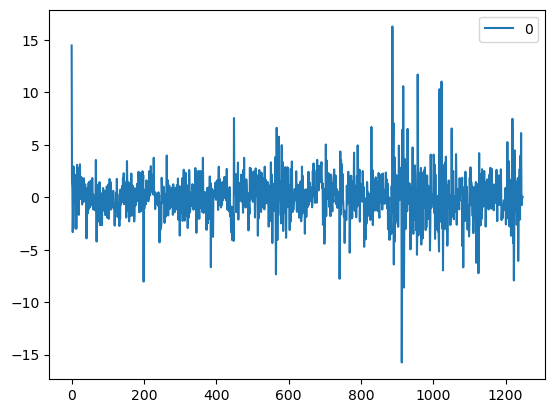

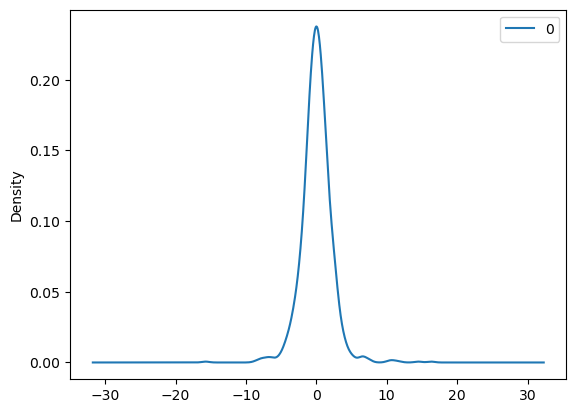

                 0
count  1248.000000
mean      0.046635
std       2.169434
min     -15.744844
25%      -1.050577
50%       0.047285
75%       1.153833
max      16.287440


In [94]:
# fitted model
model = sarimax.fit()

# summary of fit model
print(model.summary())

# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [95]:
# forcasting  
PRED    = [ x for x in model.forecast(steps=n_Test) ] 
SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
RMSE    =   (np.sum(SE)/n_Test)**0.5
RMSE

4.1211474032580995

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

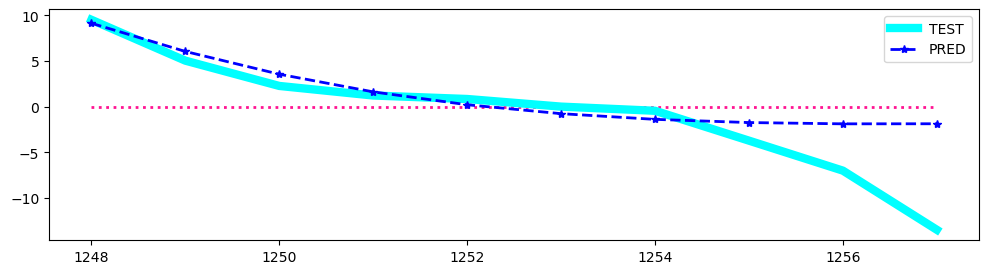

In [96]:
# visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_Test[0],T_Test[-1]], [0,0] ,  ":"  ,                color='deeppink' ,linewidth=2 )
plt.plot(        T_Test         , Test  ,  "-"  , label="TEST" , color='cyan'     ,linewidth=6 )
plt.plot(        T_Test         , PRED  , "--*" , label="PRED" , color='blue'     ,linewidth=2 )
plt.legend(); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

#####  

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> input

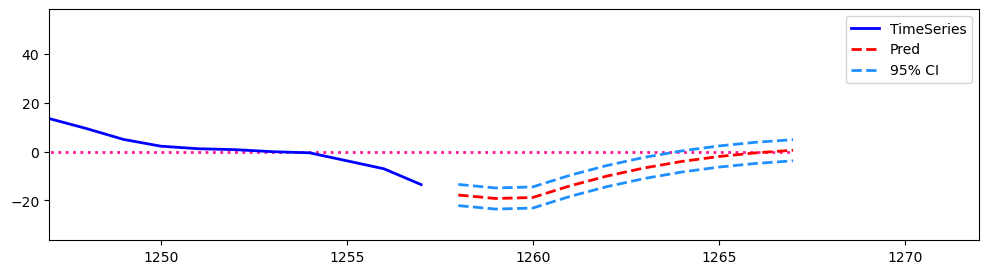

In [101]:
# auto
SD      = residuals.describe().loc['std',0]
n_Steps = n_Test 

TS = Series+Test 
n_TS =  len(    TS )
T_TS = range( n_TS )

model = SARIMAX(
    endog                   =  TS,
    order                   =  best_order,
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
).fit() 

# Forecasting Unknown Future
Pred        = [ x for x in model.forecast(steps=n_Steps) ]
T_Pred      = range( n_TS, n_TS+n_Steps )

# Confidence Interval
Pred_95_Top = [ x+2*SD for x in Pred ]
Pred_68_Top = [ x+1*SD for x in Pred ] 
Pred_68_Bot = [ x-1*SD for x in Pred ] 
Pred_95_Bot = [ x-2*SD for x in Pred ]  

# Visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_TS[0],T_Pred[-1]],   [0,0]    ,  ":" , color='deeppink'  , linewidth=2                     ) 
plt.plot(          T_TS       , TS ,  "-" , color='blue'      , linewidth=2, label="TimeSeries" )
plt.plot(          T_Pred             , Pred       , "--" , color='red'       , linewidth=2, label="Pred"       )
plt.plot(          T_Pred             , Pred_95_Top, "--" , color='dodgerblue', linewidth=2, label="95% CI"     )
#plt.plot(          T_Pred             , Pred_68_Top, "--" , color='lime'      , linewidth=2, label="68% CI"     )
#plt.plot(          T_Pred             , Pred_68_Bot, "--" , color='lime'      , linewidth=2                     )
plt.plot(          T_Pred             , Pred_95_Bot, "--" , color='dodgerblue', linewidth=2                     ) 
plt.xlim( T_Pred[-1]-2*n_Steps, T_Pred[-1]+5 )
#plt.ylim([-12,+10])
plt.legend(); plt.show()

#####   

In [102]:
T = T_Pred
T

range(1258, 1268)

In [103]:
TREND = trend*T + initial_value
TREND 

array([778.92243247, 779.31970492, 779.71697736, 780.11424981,
       780.51152225, 780.9087947 , 781.30606715, 781.70333959,
       782.10061204, 782.49788449])

In [104]:
SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A' ]
    w   = df_Cyclicity.loc[i, 'w' ]
    Lag = df_Cyclicity.loc[i,'Lag']
    sig = [ A*np.sin(w*t+Lag) for t in T ]
    SIG = [ i+j for i,j in zip(SIG,sig) ]
np.array(SIG)

array([4.35833966, 4.18153111, 4.43414183, 5.06658451, 5.96935235,
       6.98659507, 7.93520796, 8.62727403, 8.89332208, 8.60376757])

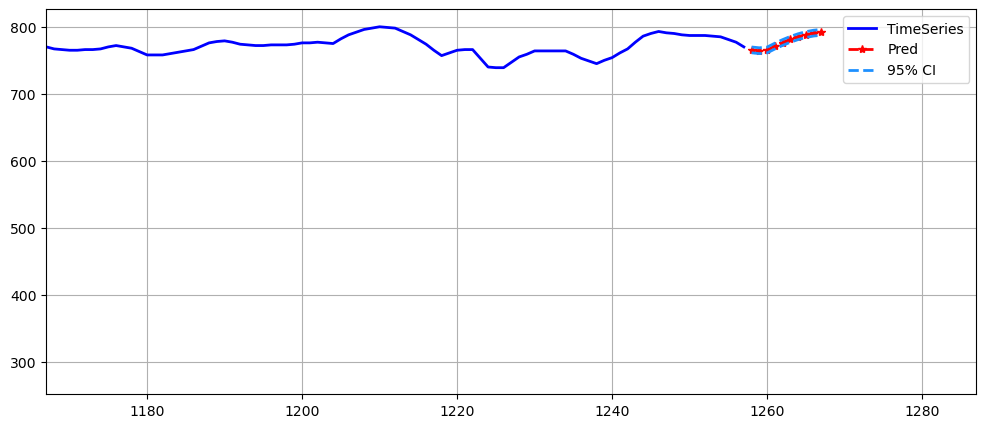

In [105]:
# Forecasting Unknown Future 
Full_Pred = [ x1+x2+x3 for x1,x2,x3 in zip(TREND,SIG,Pred) ]
#Full_Pred = [ x1+x2 for x1,x2 in zip(TREND,SIG) ]

# Confidence Interval
Pred_95_Top = [ x+2*SD for x in Full_Pred ]
Pred_68_Top = [ x+1*SD for x in Full_Pred ] 
Pred_68_Bot = [ x-1*SD for x in Full_Pred ] 
Pred_95_Bot = [ x-2*SD for x in Full_Pred ]   

# Visualizing
plt.figure( figsize=(12,5) )
plt.plot(       T_TS     , TimeSeries['Smoothed_Series'] ,  "-" , color='blue'      , linewidth=2, label="TimeSeries" )
plt.plot(          T_Pred             , Full_Pred       , "--*" , color='red'       , linewidth=2, label="Pred"       )
plt.plot(          T_Pred             , Pred_95_Top, "--" , color='dodgerblue', linewidth=2, label="95% CI"     )
#plt.plot(          T_Pred             , Pred_68_Top, "--" , color='lime'      , linewidth=2, label="68% CI"     )
#plt.plot(          T_Pred             , Pred_68_Bot, "--" , color='lime'      , linewidth=2                     )
plt.plot(          T_Pred             , Pred_95_Bot, "--" , color='dodgerblue', linewidth=2                     ) 
plt.xlim( T_Pred[-1]-10*n_Steps, T_Pred[-1]+2*n_Steps )
#plt.ylim([760,810])
plt.legend(); plt.grid('on'); plt.show()

#####   

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Smoothed Series

In [26]:
# functions
# Time-Series Generator
def generate_time_series( bSize, nSteps ):  
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, bSize, 1)
    time = np.linspace(0, 1, nSteps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))     #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
    series += 0.1 * (np.random.rand(bSize, nSteps) - 0.5)             # + noise
    return series[..., np.newaxis].astype(np.float32)

# last_time_step_mse
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [27]:
S = TimeSeries[['Smoothed_Series']].values.astype('float32') 
S = S[:,0]
S

array([325., 326., 326., ..., 781., 777., 770.], dtype=float32)

In [28]:
def under_under( S ): 
    A = [];
    for i in S:
        A.append([i])
    return A

A = under_under( S.copy() )  

In [29]:
# New_Series
import random as random

def New_Series( A ):
    New = A.copy()
    n = len(New)
    for i in range(n):  
        r = random.uniform(0.98,1.02)
        New[i][0] = New[i][0] * r
    return New   

B = New_Series( A )  
A = under_under( S ) 

In [30]:
N      = n_Steps
nBatch = 1000  

Series = []
for i in range( nBatch+N ):
    A = under_under( S ) 
    Series.append( New_Series( A ) ) 
Series = np.array(Series) 

In [54]:
# (3) Best   WaveNet 
series = Series.copy()
bSize  = series.shape[0]
nSteps = series.shape[1]-N
n_neurons = max( [20,2*N] )

a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 



model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8, 16) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))


print('Model Defined.')

Model Defined.


In [55]:
# load weights
version = '00'
try:
    model.load_weights(
          Project_Name  + '_' + version 
        , by_name       = False 
        , skip_mismatch = False 
        , options       = None 
        )
except:
    ;

In [74]:
model.compile( loss      = "mse"
             , optimizer = "adamax"     # 'sgd' 'adam' 'nadam' 'adamax'
             , metrics   = [last_time_step_mse]
             )
history = model.fit( X_train, Y_train
                   , epochs          =  10
                   , validation_data = (X_valid, Y_valid)
                   )

Epoch 1/10
23/23 [==============================] - 10s 321ms/step - loss: 1025.9431 - last_time_step_mse: 1470.2729 - val_loss: 592.1007 - val_last_time_step_mse: 696.3710
Epoch 2/10
23/23 [==============================] - 7s 299ms/step - loss: 412.5784 - last_time_step_mse: 268.7345 - val_loss: 358.0366 - val_last_time_step_mse: 213.2436
Epoch 3/10
23/23 [==============================] - 7s 299ms/step - loss: 357.8860 - last_time_step_mse: 226.3134 - val_loss: 353.2332 - val_last_time_step_mse: 228.9653
Epoch 4/10
23/23 [==============================] - 7s 309ms/step - loss: 352.5650 - last_time_step_mse: 225.6798 - val_loss: 352.3449 - val_last_time_step_mse: 229.5930
Epoch 5/10
23/23 [==============================] - 7s 301ms/step - loss: 351.3662 - last_time_step_mse: 224.6364 - val_loss: 351.3910 - val_last_time_step_mse: 231.7181
Epoch 6/10
23/23 [==============================] - 7s 302ms/step - loss: 350.3485 - last_time_step_mse: 227.1537 - val_loss: 350.4353 - val_last_t

In [75]:
Y_pred = model.predict(X_test)
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nRMSE =',np.round(MSE**.5,4))

4/4 [==============================] - 1s 79ms/step

RMSE = 18.574


In [76]:
A = np.array([ under_under(  S  ) ])   # either (the same)
#A = np.array([ under_under( S[N:] ) ])   #   or   (the same)

Y_preds = model.predict( A ) 
Preds = np.round( Y_preds[-1][-1],0 )

1/1 [==============================] - 1s 713ms/step


In [77]:

df_Preds = pd.DataFrame()
df_Preds['Preds'] = Preds

def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

Smoothed_Preds, Noise = smoother( df_Preds, 'Preds', 3 )
Smoothed_Preds = np.round( Smoothed_Preds, 0 ) 
Smoothed_Preds# Smoothing Predictions

array([776., 777., 777., 778., 779., 780., 781., 783., 784., 785.],
      dtype=float32)

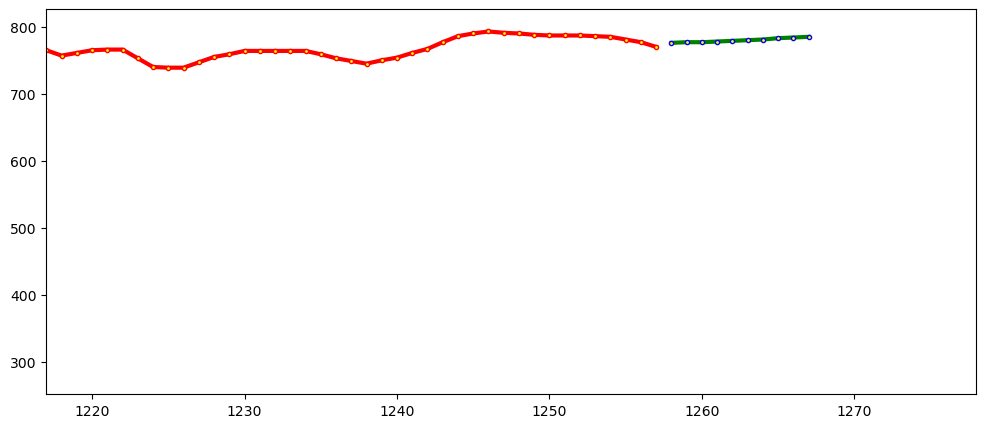

In [78]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(  range(len(S)), S
        , lw=3, c='r', ls='-'
        , marker='o', markersize=3
        , mec='red' , mew=1, mfc='yellow')

ax.plot(  np.arange(len(S),len(S)+N), Smoothed_Preds
        , lw=3, c='g', ls='-'
        , marker='o', markersize=3
        , mec='blue', mew=1, mfc='yellow' )
#plt.xlim([-20,len(S)+N+20])
#plt.ylim([0,1300])
plt.xlim( T_Pred[-1]-5*n_Steps, T_Pred[-1]+1.1*n_Steps )
#plt.ylim([760,795])

plt.savefig( Project_Name+'_Version_'+version+'_.png', dpi=120 )
plt.show()

#####   

In [79]:
# save weights
version = '00'

model.save_weights( Project_Name + '_' + version
                  , overwrite    = True 
                  , save_format  = None 
                  , options      = None 
                  )

In [80]:
# load weights
version = '00'
 
model.load_weights( Project_Name  + '_' + version 
                  , by_name       = False 
                  , skip_mismatch = False 
                  , options       = None 
                  )

#####   

In [ ]:
## save weights
#version = 'BEST'    # RMSE = 21.6
#model.save_weights( Project_Name+'_'+version, overwrite=True, save_format=None, options=None )

#####   